# Wykrywanie naczyń dna oka

## Imports

In [2509]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import img_as_ubyte, morphology
from skimage.filters import unsharp_mask, sato, threshold_otsu

## Constants

In [2510]:
PATH = "Image_09L"
ORIGINAL_PHOTO_NAME = "photos/{0}.jpg".format(PATH)
ORIGINAL_PHOTO_HOLD_OUT = "photos/{0}_1stHO.png".format(PATH)

## Functions

In [2511]:
def loadImage(file, size=400):
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [2512]:
def showImages(img1, img2, img3):
    fig = plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img3, cmap='gray')
    plt.axis('off')

In [2513]:
def preProcessing(img, optionNumbers):
    for num in optionNumbers:
        if num == 0:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        elif num == 1:
            img = unsharp_mask(img, radius=5, amount=2)

        elif num == 2:
            kernel_sharpening = np.array([[-1,-1,-1], [-1, 9,-1], [-1,-1,-1]])
            img = cv2.filter2D(img, -1, kernel_sharpening)

        elif num == 3:
            img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

        elif num == 4:
            img = cv2.equalizeHist(np.uint8(img))

        elif num == 5:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img = clahe.apply(img)

        elif num == 6:
            img = cv2.erode(img, np.ones((1, 1), np.uint8), iterations=1) 

        elif num == 7:
            img = cv2.dilate(img, np.ones((2, 2), np.uint8), iterations=1)

        elif num == 8:
            invGamma = 0.75
            table = np.array([((i / 255.0) ** invGamma) * 255
                for i in np.arange(0, 256)]).astype("uint8")
            img = cv2.LUT(img, table)

        elif num == 9:
            nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(img), connectivity=8)
            sizes = stats[1:, -1]; nb_components = nb_components - 1
            min_size = 100
            img = np.zeros((output.shape))
            for i in range(0, nb_components):
                if sizes[i] >= min_size:
                    img[output == i + 1] = 255
    return img

In [2514]:
def properProcessing(img):
    img = sato(img)
    return img

In [2515]:
def removeBorder(original, img):
    for i in range(len(original)):
        for j in range(len(original[0])):
            if original[i][j] == False:
                img[i][j] = 0
    return img 

In [2516]:
def darkenVessels(img):
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] < 70:
                img[i][j] = 0
    return img 

In [2517]:
def checkEffectivity(img, ho):
    TP = 0
    FP = 0
    FN = 0
    TN = 0

    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i, j] > 0 and ho[i, j] > 0:
                TP += 1
            elif img[i, j] == 0 and ho[i, j] == 0:
                TN += 1
            elif img[i, j] == 0 and ho[i, j] > 0:
                FP += 1
            elif img[i, j] > 0 and ho[i, j] == 0:
                FN += 1

    print('Macierz pomylek:\n{} TP\n{} FP\n{} FN\n{} TN'.format(TP, FP, FN, TN))
    print('Sensitivity: %5.3f' % (TP / (TP + FN)))
    print('Specificity: %5.3f' % (TN / (TN + FP)))
    print('Accuracy: %5.3f\n' % ((TP + TN) / (TP + FP + TN + FN)))

## Main

Macierz pomylek:
6630 TP
5891 FP
1314 FN
146165 TN
Sensitivity: 0.835
Specificity: 0.961
Accuracy: 0.955



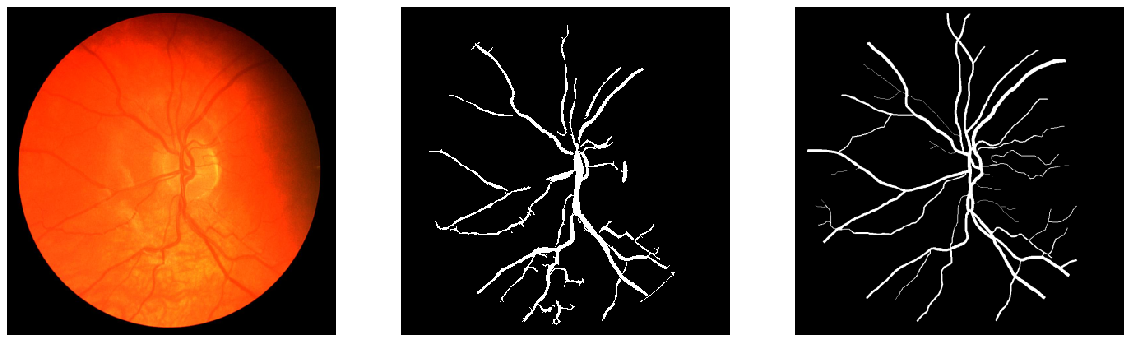

In [2518]:
originalImage = loadImage(ORIGINAL_PHOTO_NAME)

preparedImage = preProcessing(originalImage, [0, 5, 2, 8, 6])
preparedImage = darkenVessels(preparedImage)
resultImage = properProcessing(preparedImage)
resultImage = removeBorder(preProcessing(originalImage, [0]) > 50, resultImage)
resultImage = preProcessing(resultImage, [1, 3])
resultBinary = preProcessing(resultImage > 28, [9])

holdOut = preProcessing(loadImage(ORIGINAL_PHOTO_HOLD_OUT), [0, 3])
showImages(originalImage, resultBinary, holdOut)
checkEffectivity(resultBinary, holdOut) # extend for 5+ images

# good results for: 05R, 05L, 04R, 04L, 09R, 09L